In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

In [ ]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True,
    use_gradient_checkpointing = True
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.4: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.90G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers = True,
    finetune_language_layers = True,
    finetune_attention_layers = True,
    finetune_mlp_layers = True,
    r = 16,
    lora_alpha = 32,
    lora_dropout = 0,
    bais = "none",
    random_state = 3407
)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("moonworks/lunara-aesthetic", split="train")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00006.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

data/train-00001-of-00006.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00002-of-00006.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00003-of-00006.parquet:   0%|          | 0.00/492M [00:00<?, ?B/s]

data/train-00004-of-00006.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

data/train-00005-of-00006.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from PIL import Image

def resize_image(sample, size=384):
  sample["image"] = sample["image"].resize((size,size))
  return sample

dataset = dataset.map(
    resize_image,
    fn_kwargs = {"size": 384}
)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['image', 'prompt', 'region', 'category', 'topic'],
    num_rows: 2000
})

In [ ]:
def convert_to_conversation(sample):
  instruction = (
      "Write a detailed image generation prompt for the given image.\n"
      f"Region: \n"
      f"Category: \n"
      f"Topic: "
  )
  assistant_output = (
      f"Prompt: {sample['prompt']}\n"
      f"Region: {sample['region']}\n"
      f"Category: {sample['category']}\n"
      f"Topic: {sample['topic']}"
  )

  converstion = [
      {
          "role": "user",
          "content": [
              {"type" : "text", "text": instruction},
              {"type" : "image", "image": sample["image"]},
          ],
      },
      {
          "role": "assistant",
          "content": [
              {"type": "text", "text": assistant_output},
          ],
      },
  ]
  return {"messages": converstion}

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write a detailed image generation prompt for the given image.\nRegion: \nCategory: \nTopic: '},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=384x384>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Prompt: Coastal cliffside cottage, golden hour, soft waves, painterly style, wide lens, serene mood.\nRegion: nordic\nCategory: painting\nTopic: Nature & Landscape'}]}]}

In [ ]:
FastVisionModel.for_inference(model)

image = dataset[2]["image"]

instruction = (
    "Write a detailed image generation prompt for the given image.\n"
    "Region: x\n"
    "Category: x\n"
    "Topic: x"
)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],

    }
]

input_text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt"
)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt"
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)

_ = model.generate(
    **inputs,
    streamer = text_streamer,
    max_new_tokens = 1024,
    use_cache = True,
    temperature = 0.2,
    top_p = 0.95,
)


Certainly! Here is a detailed image generation prompt for the given image:

**Region:** A cozy, sunlit corner of a room.

**Category:** Still life painting.

**Topic:** A serene and artistic arrangement on a windowsill.

### Description:
- **Lighting:** The scene is bathed in soft, natural light streaming through a partially open window on the left side of the image. The sunlight creates a warm, golden glow that illuminates the objects on the windowsill.
- **Objects on the Windowsill:**
  - **Flower Vase:** A white ceramic vase holds a bouquet of dried flowers with a mix of yellow and orange hues. The flowers have a rustic, autumnal feel to them.
  - **Painting Supplies:** To the left of the vase, there is a small, open paint palette containing a few strokes of orange paint. Two wooden paintbrushes rest inside the palette.
  - **Apple:** A small, white apple with some brown spots sits near the bottom right of the vase. It appears to be a decorative element rather than a fruit meant for

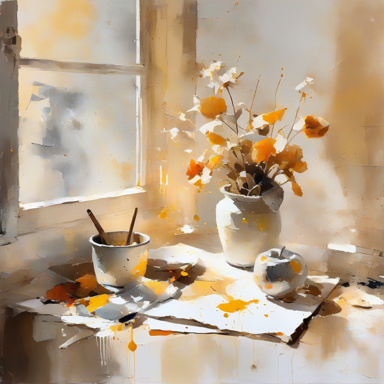

In [ ]:
from IPython.display import display
display(image)

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps= 4,
        warmup_steps = 5,
        max_steps = 30,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "output",
        report_to = "none",

        #must
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,

    ),
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.945 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,000 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,521,536 of 8,343,688,192 (0.62% trained)


Step,Training Loss
1,7.210000
2,7.189200
3,6.620800
4,5.799100
5,4.710500
6,3.780900
7,3.105900
8,2.837100
9,2.314700
10,2.015800


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

332.8028 seconds used for training.
5.55 minutes used for training.
Peak reserved memory = 7.615 GB.
Peak reserved memory for training = 0.67 GB.
Peak reserved memory % of max memory = 51.659 %.
Peak reserved memory for training % of max memory = 4.545 %.


In [ ]:
from unsloth import FastVisionModel
import torch
from transformers import TextStreamer

FastVisionModel.for_inference(model)

image = dataset[2]["image"].resize((384,384))

instruction = (
    "Write a detailed image generation prompt for the given image.\n"
    "Region: x\n"
    "Category: x\n"
    "Topic: x"
)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],

    }
]

input_text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt"
)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt"
).to("cuda")

text_streamer = TextStreamer(tokenizer, skip_prompt = True)

_ = model.generate(
    **inputs,
    streamer = text_streamer,
    max_new_tokens = 1024,
    use_cache = True,
    temperature = 0.2,
    top_p = 0.95,
)

Prompt: Soft light on autumn still life with dried leaves, rustic vase, and apple, painterly style.
Region: general
Category: digital
Topic: Everyday Life<|im_end|>


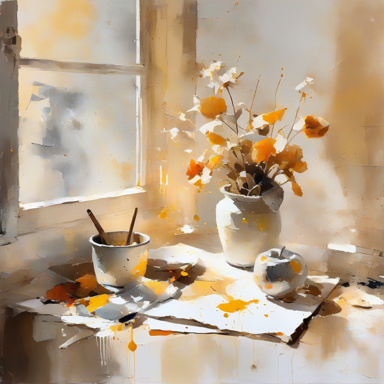

In [ ]:
from IPython.display import display, Markdown

display(image)